In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/RecSys/hw2 -r ./
%cd hw2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/hw2


### Data preprocessing

In [7]:
import pandas as pd
import numpy as np
import scipy.sparse as sp


In [ ]:
!unzip kkbox-music-recommendation-challenge.zip -d data
!7za e data/train.csv.7z
!7za e data/songs.csv.7z
!7za e data/members.csv.7z
!7za e data/song_extra_info.csv.7z

In [8]:
!ls -la

total 1698036
drwx------ 4 root root      4096 Nov  4 05:06 .
drwxr-xr-x 1 root root      4096 Nov  4 00:35 ..
drwxr-xr-x 2 root root      4096 Nov  4 00:36 data
drwx------ 2 root root      4096 Nov  4 05:04 hw2
-rw------- 1 root root     70970 Nov  4 05:04 hw2.ipynb
-rw------- 1 root root 361666592 Nov  4 05:04 kkbox-music-recommendation-challenge.zip
-rw-r--r-- 1 root root   2503827 Sep 22  2017 members.csv
-rw-r----- 1 root root 181010294 Sep 29  2017 song_extra_info.csv
-rw-r--r-- 1 root root 221828666 Sep 22  2017 songs.csv
-rw-r--r-- 1 root root 971675848 Sep 22  2017 train.csv


In [9]:
train = pd.read_csv('train.csv', dtype={'msno' : 'category',
                                        'source_system_tab' : 'category',
                                        'source_screen_name' : 'category',
                                        'source_type' : 'category',
                                        'target' : np.uint8,
                                        'song_id' : 'category'})
songs = pd.read_csv('songs.csv',dtype={'genre_ids': 'category',
                                       'language' : 'category',
                                       'artist_name' : 'category',
                                       'composer' : 'category',
                                       'lyricist' : 'category',
                                       'song_id' : 'category'})
members = pd.read_csv('members.csv',dtype={'city' : 'category',
                                           'bd' : np.uint8,
                                           'gender' : 'category',
                                           'registered_via' : 'category'},
                      parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv')

In [10]:
train.count()

msno                  7377418
song_id               7377418
source_system_tab     7352569
source_screen_name    6962614
source_type           7355879
target                7377418
dtype: int64

In [9]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1


Merge with songs info

In [11]:
songs.head(3)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0


In [10]:
train = train.merge(songs, on='song_id', how='left')

In [11]:
del songs

In [13]:
songs_extra.head(3)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303


In [12]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra.isrc.apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

In [13]:
train = train.merge(songs_extra, on = 'song_id', how = 'left')

In [14]:
del songs_extra

In [10]:
print(train.song_length.isna().sum())
print(train.song_length.mean())

114
245120.9693600806


In [15]:
train.song_length.fillna(250000, inplace=True)

In [12]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0


In [13]:
print(train.song_length.between(0, 100000).sum())
print(train.song_length.between(100000, 150000).sum())
print(train.song_length.between(150000, 200000).sum())
print(train.song_length.between(200000, 300000).sum())
print(train.song_length.between(300000, 400000).sum())
print(train.song_length.between(400000, 500000).sum())

62121
119252
911614
5600337
615219
41390


In [16]:
train['is_short_song'] = train.song_length.apply(lambda row: row < 150000)
train['is_long_song'] = train.song_length.apply(lambda row: row > 300000)

In [17]:
def n_count(row):
    if pd.isna(row):
        return 0
    else:
        return sum(map(row.count, ['|', '/', '\\', ';'])) + 1

train['n_genre_ids'] = train.genre_ids.apply(n_count)
train.n_genre_ids.fillna(0, inplace=True)
train.n_genre_ids = train.n_genre_ids.astype(np.int8)

In [18]:
train['n_lyricist'] = train.lyricist.apply(n_count)
train.n_lyricist.fillna(0, inplace=True)
train.n_lyricist = train.n_lyricist.astype(np.int8)

In [19]:
train['n_composer'] = train.composer.apply(n_count)
train.n_composer.fillna(0, inplace=True)
train.n_composer = train.n_composer.astype(np.int8)

In [14]:
print('Mean of genre numbers', train.n_genre_ids.mean())
print('Rows with >1 genre', train[train.n_genre_ids > 1].n_genre_ids.count(), 'out of 7.3+M')
max_genre = 0
for genres in train.genre_ids:
    if pd.isna(genres):
        continue
    for g in genres.split('|'):
        if max_genre < int(g):
            max_genre = int(g)
print('Max genre value', max_genre)

Mean of genre numbers 1.0373533125003898
Rows with >1 genre 340317 out of 7.3+M
Max genre value 2248


We could make one-hot encoding feature, but it's too sparse. Also introducing 2k new features seems like an overkill since there are not that many multi-genred rows. So, I will just sort the genres (assuming they are equally suitable).

In [20]:
def sort_genres(row):
    if pd.isna(row) or row.count('|') == 0:
        return row
    genres = list(map(int, row.split('|')))
    return '|'.join(list(map(str, sorted(genres))))

train.genre_ids = train.genre_ids.apply(sort_genres)

Artist names listings are not unified with '|'. There are 'featuring', 'and', etc.
I am not sure what to do with 'Various Artists', so I just left them as 1 artist.

In [60]:
train.artist_name.unique()

['Bastille', 'Various Artists', 'Nas', 'Soundway', 'Brett Young', ..., 'Alicia Keys featuring Drake', 'Fatal Bazooka Feat Yelle et Christelle', 'JD Samson & MEN', '2002 Latin Love Songs', 'Salvina y Miren al Lobo']
Length: 40583
Categories (40582, object): ['Bastille', 'Various Artists', 'Nas', 'Soundway', ...,
                             'Fatal Bazooka Feat Yelle et Christelle', 'JD Samson & MEN', '2002 Latin Love Songs',
                             'Salvina y Miren al Lobo']

In [21]:
def artist_count(row):
    if pd.isna(row):
        return 0
    else:
        row = row.lower()
        return x.count('and') + x.count('feat') + x.count('&') + x.count(',') + x.count('|')

train['n_artist'] = train.artist_name.apply(n_count)
train.n_artist.fillna(0, inplace=True)
train.n_artist = train.n_artist.astype(np.int8)

Judging by artst_name, I think language 52 is for English.

In [93]:
train[train.language == '52.0'].artist_name.head(10)

0             Bastille
1      Various Artists
2                  Nas
4          Brett Young
5            Desiigner
7         Thomas Rhett
8          OneRepublic
9          OneRepublic
10    Lindsey Stirling
23         John Lennon
Name: artist_name, dtype: category
Categories (222363, object): ['!Dela Dap', '#1 Beatles Now',
                              '#1 Club Hits - Best Of Dance & Techno',
                              '#1 Club Hits 2010 - Best Of Dance Techno (50 ..., ..., '야콥| 레이나| 우노| 데이데이', '오소연', '장윤정| 서병순',
                              '플레이송스 (PLAYSONGS)']

In [22]:
train['is_eng_song'] = train.language.apply(lambda row: row == '52.0')
train.is_eng_song.fillna('False', inplace=True)
train.is_eng_song = train.is_eng_song.astype(bool)

How often does user listen to this song

In [23]:
n_song_played = {k: v for k, v in train.song_id.value_counts().iteritems()}  
train['n_song_played'] = train.song_id.apply(lambda row: n_song_played.get(row, 0)).astype(np.int64)

In [24]:
del n_song_played

In [25]:
n_artist_played = {k: v for k, v in train.artist_name.value_counts().iteritems()}  
train['n_artist_played'] = train.artist_name.apply(lambda row: n_artist_played.get(row, 0))
train.n_artist_played.fillna(0, inplace=True)
train.n_artist_played = train.n_artist_played.astype(np.int64)

In [26]:
del n_artist_played

Now merging with members

In [27]:
members['membership_days'] = members.expiration_date.subtract(members.registration_init_time).dt.days.astype(int)

members['registration_year'] = members.registration_init_time.dt.year
members['registration_month'] = members.registration_init_time.dt.month
members['registration_day'] = members.registration_init_time.dt.day
members = members.drop(['registration_init_time'], axis=1)

members['expiration_year'] = members.expiration_date.dt.year
members['expiration_month'] = members.expiration_date.dt.month
members['expiration_day'] = members.expiration_date.dt.day
members = members.drop(['expiration_date'], axis=1)

train = train.merge(members, on='msno', how='left')

In [28]:
del members

In [28]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,is_short_song,is_long_song,n_genre_ids,n_lyricist,n_composer,n_artist,is_eng_song,n_song_played,n_artist_played,city,bd,gender,registered_via,membership_days,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,False,False,1,0,2,1,True,215,1140,1,0,NaN,7,2103,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,False,False,1,0,0,1,True,1,303616,13,24,female,9,2301,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,False,False,1,0,1,1,True,4,289,13,24,female,9,2301,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,False,False,1,0,1,1,False,1,1,13,24,female,9,2301,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,False,False,1,0,3,1,True,412,427,1,0,NaN,7,2103,2012,1,2,2017,10,5


In [29]:
train.msno = train.msno.astype('category')
train.song_id = train.song_id.astype('category')
train.genre_ids = train.genre_ids.astype('category')

In [30]:
train.dtypes

msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                   uint8
song_length            float64
genre_ids             category
artist_name           category
composer              category
lyricist              category
language              category
song_year              float64
is_short_song             bool
is_long_song              bool
n_genre_ids               int8
n_lyricist                int8
n_composer                int8
n_artist                  int8
is_eng_song               bool
n_song_played            int64
n_artist_played          int64
city                  category
bd                       uint8
gender                category
registered_via        category
membership_days          int64
registration_year        int64
registration_month       int64
registration_day         int64
expiration_year          int64
expiration_month         int64
expirati

In [25]:
train.to_csv('full_train.csv')

In [26]:
!zip train.zip full_train.csv

  adding: full_train.csv (deflated 65%)


In [ ]:
from google.colab import files
files.download('train.zip') 

### GBDT


In [32]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train, test_size=0.2)

In [33]:
del train

In [39]:
print(train_df.msno.count())
print(test_df.msno.count())

5901934
1475484


In [34]:
X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target'].values
X_test = test_df.drop(['target'], axis=1)
y_test = test_df['target'].values

##XGBoost + tuning

I tried several runs for XGBoost. Here are results for the best run with features (you can see them in SHAP values) and parameters that showed the best results.

In [35]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import scipy.stats as st

In [36]:
def process_categorical(df):
    cols = df.select_dtypes(include=['category']).columns
    for col in cols:
        df[col+'_code'] = df[col].cat.codes
    return df.drop(cols, axis=1)
X_test = process_categorical(X_test)
X_test.head(3)

,song_length,song_year,is_short_song,is_long_song,is_eng_song,n_song_played,n_artist_played,bd,membership_days,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,msno_code,song_id_code,source_system_tab_code,source_screen_name_code,source_type_code,genre_ids_code,artist_name_code,composer_code,lyricist_code,language_code,city_code,gender_code,registered_via_code
4576657,290063.0,2016.0,False,False,False,11521,186776,21,1767,2012,11,8,2017,9,10,18505,181045,3,15,7,316,22669,32934,13539,4,19,1,2
2195619,267807.0,2016.0,False,False,False,156,335,23,885,2015,4,28,2017,9,29,22308,146990,3,7,3,330,24033,33294,15165,4,6,0,5
5534092,149524.0,NaN,True,False,True,2,17163,0,1955,2012,5,24,2017,9,30,24079,127641,3,0,0,111,25315,120772,-1,8,0,-1,4


In [37]:
X_train = process_categorical(X_train)

In [46]:
X_train.to_csv('x_train.csv')
np.savetxt("y_train.csv", y_train, delimiter=",")
X_test.to_csv('x_test.csv')
np.savetxt("y_test.csv", y_test, delimiter=",")

In [50]:
from sklearn.metrics import roc_auc_score

def xgb_objective(space):
    classifier = xgb.XGBClassifier(**space)
    success = False
    attempts = 0
    model = None
    while not success and attempts < 2:
        try:
            model = classifier.fit(X_train, y_train)
            success = True
        except Exception as e:
            attempts += 1
            print(e)
            print('Try again')
        
    prediction = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, prediction)
    print('ROC-AUC: {}'.format(roc_auc))
    return {'rocauc': roc_auc, 'status': STATUS_OK }

In [51]:
static_params_xgb = {
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'silent': 0
}

In [ ]:
%%time

max_depth_choice = [3, 5, 10]
lr_choice = [0.01, 0.1, 0.5]
estimators_choice = [100, 300, 500]


space_xgb = {
    # Optimize
    'max_depth': hp.choice('max_depth', max_depth_choice),
    'learning_rate': hp.choice('learning_rate', lr_choice),
    'n_estimators': hp.choice('n_estimators', estimators_choice),
    
    **static_params_xgb
}

trials_xgb = Trials()
best_xgb = fmin(fn=xgb_objective,
            space=space_xgb,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_xgb)

In [47]:
params_xgb = {
    'max_depth': max_depth_choice[best_xgb['max_depth']],
    'learning_rate': lr_choice[best_xgb['learning_rate']],
    'n_estimators': estimators_choice[best_xgb['n_estimators']],
}
model = xgb.XGBClassifier(**{**static_params_xgb, **params_xgb})
model.fit(X_train, y_train)

[05:22:04] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.75,
              eval_metric='auc', gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [54]:
prediction = model.predict(X_test)
print('General auc', roc_auc_score(y_test, prediction))

General auc 0.7129236544548003


In [62]:
X_train.iloc[[4576657, 2195619], :]

,song_length,song_year,is_eng_song,n_song_played,n_artist_played,bd,registration_year,registration_month,expiration_year,expiration_month,msno_code,song_id_code,source_system_tab_code,source_screen_name_code,source_type_code,genre_ids_code,artist_name_code,composer_code,lyricist_code,language_code,city_code,gender_code
3916034,311405.0,2007.0,False,271,11748,38,2007,1,2018,6,3661,269380,5,12,6,330,26099,88420,38488,4,16,0
4369534,208492.0,2016.0,True,7697,44215,19,2015,6,2017,8,22988,2155,0,10,5,111,18654,1868,578,8,19,1


In [60]:
from sklearn.model_selection import KFold


def kfold_eval(model_fn, k=5):
    kfold = KFold(k)
    gts, preds = [], []
    for i, (train_ids, test_ids) in enumerate(kfold.split(X_train)):
        print(train_ids)
        print('Fold', i + 1)
        X_tr, X_te = X_train.iloc[train_ids], X_train[test_ids]
        y_tr, y_te = y_train[train_ids], y_train[test_ids]

        model = model_fn()
        model.fit(X_tr, y_tr)
        prediction = model.predict(X_te)
        gts.append(y_te)
        preds.append(prediction)
    return gts, preds

In [56]:
def roc_auc(gts, preds):
    for i, (gt, pred) in enumerate(zip(gts, preds)):
        roc_auc = roc_auc_score(gt, pred)
        print('Fold', i, round(roc_auc, 2))

In [63]:
xgb_gts, xgb_preds = kfold_eval(xgb.XGBClassifier(**{**static_params_xgb, **params_xgb}))
roc_auc(xgb_gts, xgb_preds)

Fold 0 0.711
Fold 1 0.712
Fold 2 0.712
Fold 3 0.711
Fold 4 0.712


SHAP values

In [70]:
shap_ids = np.random.choice(X_train.index, 1000, replace=False)
shap_df = X_train.loc[shap_ids, :]

In [ ]:
!pip install shap

In [73]:
import shap

explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
shap_vals = explainer.shap_values(shap_df)

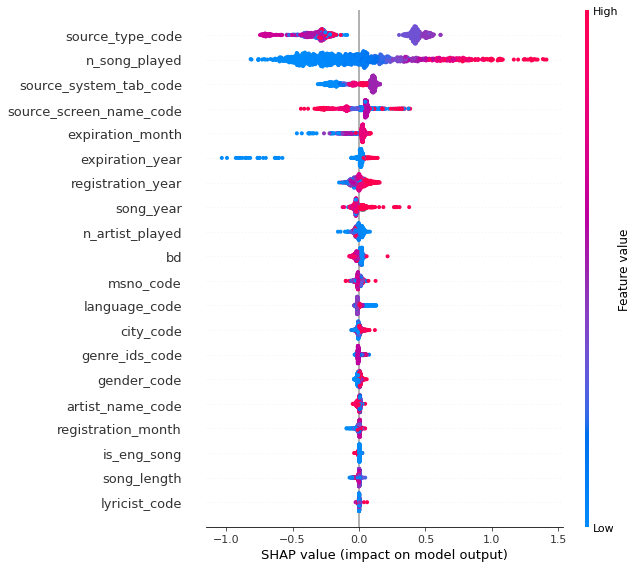

In [74]:
shap.summary_plot(shap_vals, shap_df)

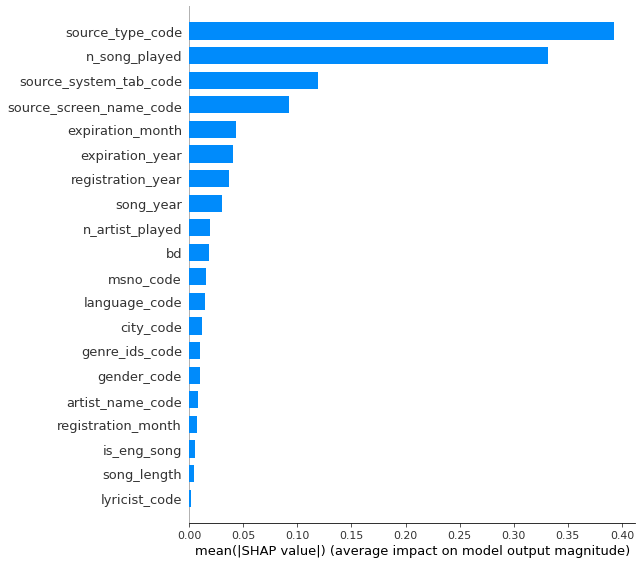

In [76]:
shap.summary_plot(shap_vals, shap_df, plot_type='bar')

### Embeddings